In [3]:
import os
import tensorflow as tf


logger = tf.get_logger().setLevel("FATAL") #

In [20]:
from PIL import Image
import os
import numpy as np
import tensorflow as tf
from keras import ops
from keras.layers import StringLookup
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
import json
from tqdm import tqdm
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

In [5]:


# Check if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
if not physical_devices:
    print("No GPU detected.")
else:
    print("GPU detected:", physical_devices)



a = tf.random.normal([10000, 10000])
b = tf.random.normal([10000, 10000])
c = tf.matmul(a, b)
print(c)

GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1744281418.159388     776 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744281418.218382     776 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744281418.221941     776 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744281418.229737     776 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

tf.Tensor(
[[-167.17772   -131.55443    138.19144   ...   34.401733    68.70626
   -60.972565 ]
 [  37.25131    -77.15524     -1.0356978 ... -113.19813    101.53538
   -18.937704 ]
 [-137.8328      66.21748    153.93466   ...  147.01152     59.893772
   -15.9551   ]
 ...
 [   9.239711    69.56954     79.18323   ...  -34.032032   216.8913
    28.092178 ]
 [  31.5487     265.7277     -31.883104  ...   86.90653      4.9800177
  -237.45415  ]
 [  52.958256    20.238918   -39.509113  ...  145.43239   -109.23808
   -95.66214  ]], shape=(10000, 10000), dtype=float32)


In [6]:
gpu_devices = tf.config.list_physical_devices('GPU')
if not gpu_devices:
    print("TensorFlow is using the CPU.")
else:
    print(f"TensorFlow is using the following GPU(s): {gpu_devices}")

TensorFlow is using the following GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
dataPath = "../trainingData/" #FILEPATH


--- words.txt ---------------------------------------------------------------#

 iam database word information

 format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A

     a01-000u-00-00  -> word id for line 00 in form a01-000u
     ok              -> result of word segmentation
                            ok: word was correctly
                            er: segmentation of word can be bad

     154             -> graylevel to binarize the line containing this word
     1               -> number of components for this word NOTE: dont think this exists idk why
     408 768 27 51   -> bounding box around this word in x,y,w,h format
     AT              -> the grammatical tag for this word, see the
                        file tagset.txt for an explanation
     A               -> the transcription for this word


In [8]:

j = open("imagePaths.json","r")

if len(j.read()) == 0:
    text = open(dataPath + "ascii/words.txt","r").read().splitlines()
    text = text[18:] #first 18 lines is metadata
    images = []
    for data in text:
        parts = data.split(" ")
        word = parts[-1]
        tmp = parts[0].split("-")
        path = dataPath + "augmentedWords/IAM/" + tmp[0]+"/"+tmp[0]+"-"+tmp[1]+"/"+parts[0]+"/"
        if len(word) == 1:
            inDir = os.listdir(path)
            for f in inDir:
                images.append([os.path.join(path+f), word]) #last 2 are width and height ord() to convert to ascii

    def recurSearch (path,letter):
        files = os.listdir(path)
        if files[0][:5] == "image":
            for f in files:
                images.append([os.path.join(path,f), letter])
        else:
            for f in files:
                recurSearch(os.path.join(path,f), letter)

    letters = os.listdir(dataPath + "augmentedWords/EMNIST/")
    print (letters)
    print ([chr(int(ltr,16)) for ltr in letters])
    for ltr in letters: #ltr will be in hex (gives ascii value)
        path = dataPath + "augmentedWords/EMNIST/"+ltr+"/"
        intLtr = chr(int(ltr,16))
        recurSearch(path,intLtr)
    
    with open ("imagePaths.json","w") as j:
        json.dumps(images)
else:
    with open ("imagePaths.json","r") as j:
        images = json.load(j)
images = np.array(images)
np.random.shuffle(images)
np.random.shuffle(images)


print (images[0:10])


#around 1 min

['35', '73', '4f', '6b', '46', '79', '58', '62', '52', '42', '54', '64', '4e', '6d', '48', '47', '51', '71', '7a', '49', '44', '67', '45', '6c', '68', '43', '63', '6a', '55', '4b', '57', '78', '59', '70', '38', '33', '32', '72', '53', '37', '6e', '50', '65', '4d', '39', '41', '66', '56', '30', '6f', '61', '31', '69', '5a', '34', '36', '75', '77', '76', '4a', '4c', '74']
['5', 's', 'O', 'k', 'F', 'y', 'X', 'b', 'R', 'B', 'T', 'd', 'N', 'm', 'H', 'G', 'Q', 'q', 'z', 'I', 'D', 'g', 'E', 'l', 'h', 'C', 'c', 'j', 'U', 'K', 'W', 'x', 'Y', 'p', '8', '3', '2', 'r', 'S', '7', 'n', 'P', 'e', 'M', '9', 'A', 'f', 'V', '0', 'o', 'a', '1', 'i', 'Z', '4', '6', 'u', 'w', 'v', 'J', 'L', 't']
[['../trainingData/augmentedWords/EMNIST/35/hsf_2/hsf_2_00485/image_0_9153.jpeg'
  '5']
 ['../trainingData/augmentedWords/EMNIST/43/train_43/train_43_05192/image_0_912.jpeg'
  'C']
 ['../trainingData/augmentedWords/EMNIST/56/train_56/train_56_00158/image_0_9922.jpeg'
  'V']
 ['../trainingData/augmentedWords/EMNIST/

In [9]:
#TOO MUCH DATA here to shorten it so it doesnt take forever for testing
images = images[:1000000]

In [10]:
trainRatio = 0.8
valRatio = 0.15
trainImages = images[0:int(len(images) * trainRatio)]
valImages = images[int(len(images) * trainRatio):int(len(images) * (trainRatio + valRatio))]
testImages = images[int(len(images) * (trainRatio + valRatio)):]

In [11]:
unique_labels = sorted(set(images[:, 1]))  # Unique characters
num_classes = len(unique_labels)

In [12]:
label_encoder = tf.keras.layers.StringLookup(vocabulary=unique_labels, num_oov_indices=0)
def load_image(image_path, label):
    image = tf.io.read_file(image_path)  # Read image
    image = tf.image.decode_jpeg(image, channels=3)  # Decode as RGB
    image = tf.image.resize_with_pad(image,224,224) # Resize to match input shape of VGG16
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0, 1]
    
    image = preprocess_input(image)  # Preprocess input for VGG16d
    label = label_encoder(label)
    return image, label
print(load_image(images[0,0],images[0,1]))


(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 151.061   ,  138.22101 ,  131.32    ],
        [ 151.061   ,  138.22101 ,  131.32    ],
        [ 151.061   ,  138.22101 ,  131.32    ],
        ...,
        [ 140.1976  ,  127.35761 ,  120.45661 ],
        [ 134.061   ,  121.221   ,  114.32    ],
        [-103.939   , -116.779   , -123.68    ]],

       [[ 151.061   ,  138.22101 ,  131.32    ],
        [ 151.061   ,  138.22101 ,  131.32    ],
        [ 151.061   ,  138.22101 ,  131.32    ],
        ...,
        [  75.99131 ,   63.151314,   56.250313],
        [  67.63946 ,   54.79946 ,   47.89846 ],
        [-103.939   , -116.779   , -123.68    ]],

       [[ 151.061   ,  138.22101 ,  131.32    ],
        [ 151.061   ,  138.22101 ,  131.32    ],
        [ 151.061   ,  138.22101 ,  131.32    ],
        ...,
        [ -26.100685,  -38.94068 ,  -45.841682],
        [ -37.97489 ,  -50.814888,  -57.71589 ],
        [-103.939   , -116.779   , -123.68    ]],

       ...,

    

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target' (ignoring feature)
+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices((list(trainImages[:,0]), list(trainImages[:,1])))
val_ds = tf.data.Dataset.from_tensor_slices((list(valImages[:,0]), list(valImages[:,1])))
test_ds = tf.data.Dataset.from_tensor_slices((list(testImages[:,0]), list(testImages[:,1])))

In [14]:
BATCH_SIZE = 32
train_ds = train_ds.map(load_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(load_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(load_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.summary()
# Freeze base model (optional, for feature extraction)
base_model.trainable = False  

# Add custom classifier
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Multi-class classification
])


# Compile model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [16]:
import keras
class CustomSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        self.model.save(f'savedModels/model_at_epoch_{epoch+1}.h5')
saver = CustomSaver()

In [17]:
# Train the model
EPOCHS = 50  # Change as needed

history = model.fit(train_ds, validation_data=val_ds, callbacks = [saver], epochs=EPOCHS)

Epoch 1/50


2025-04-09 15:20:59.587748: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90701
W0000 00:00:1744212059.639723    1228 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212059.655930    1228 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212059.657049    1228 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212059.660934    1228 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212059.662580    1228 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212059.664207    1228 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212059.674308    1228 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212059.675920    1228 gpu_

    1/25000 [..............................] - ETA: 18:15:09 - loss: 4.7012 - accuracy: 0.0000e+00

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f

    2/25000 [..............................] - ETA: 5:13:01 - loss: 7.9833 - accuracy: 0.0625     

W0000 00:00:1744212062.274664    1232 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212062.282212    1232 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212062.289376    1232 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212062.298295    1232 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212062.302211    1232 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212062.325820    1230 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212062.332049    1230 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212062.340522    1230 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212062.347998    1230 gp

    3/25000 [..............................] - ETA: 4:10:02 - loss: 8.8855 - accuracy: 0.0833

W0000 00:00:1744212062.682124    1230 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212062.698040    1230 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212062.710541    1230 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212062.712548    1230 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212062.714290    1230 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212062.715724    1230 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212062.718683    1230 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212062.720916    1230 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212062.723865    1230 gp

    4/25000 [..............................] - ETA: 3:48:53 - loss: 9.9534 - accuracy: 0.0781

W0000 00:00:1744212063.090288    1228 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212063.098504    1228 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212063.106112    1228 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212063.114520    1228 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212063.119255    1228 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212063.130601    1228 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212063.146189    1228 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212063.158767    1228 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744212063.161062    1228 gp

25000/25000 [==============================] - ETA: 0s - loss: 1.4514 - accuracy: 0.5730      

W0000 00:00:1744213398.452475    1233 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744213398.453061    1233 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744213398.453612    1233 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744213398.454870    1233 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744213398.455659    1233 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744213398.456414    1233 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744213398.457872    1233 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744213398.458724    1233 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744213398.460175    1233 gp

25000/25000 [==============================] - 1343s 54ms/step - loss: 1.4514 - accuracy: 0.5730 - val_loss: 2.3773 - val_accuracy: 0.6010
Epoch 2/50
25000/25000 [==============================] - ETA: 0s - loss: 1.1436 - accuracy: 0.6509   

W0000 00:00:1744214723.392120    1228 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744214723.392695    1228 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744214723.393232    1228 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744214723.394035    1228 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744214723.395388    1228 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744214723.396548    1228 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744214723.398001    1228 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744214723.398784    1228 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744214723.400227    1228 gp

25000/25000 [==============================] - 1324s 53ms/step - loss: 1.1436 - accuracy: 0.6509 - val_loss: 14.0155 - val_accuracy: 0.5976
Epoch 3/50
25000/25000 [==============================] - ETA: 0s - loss: 1.0171 - accuracy: 0.6837   

W0000 00:00:1744216049.934113    1230 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744216049.937905    1230 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744216049.942158    1230 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744216049.945817    1230 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744216049.949645    1230 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744216049.954178    1230 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744216049.958021    1230 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744216049.961924    1230 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744216049.967071    1230 gp

25000/25000 [==============================] - 1326s 53ms/step - loss: 1.0171 - accuracy: 0.6837 - val_loss: 47.2949 - val_accuracy: 0.5783
Epoch 4/50
25000/25000 [==============================] - 1335s 53ms/step - loss: 0.9419 - accuracy: 0.7045 - val_loss: 122.6036 - val_accuracy: 0.5677
Epoch 5/50
25000/25000 [==============================] - 1328s 53ms/step - loss: 0.8899 - accuracy: 0.7198 - val_loss: 240.5634 - val_accuracy: 0.5485
Epoch 6/50
16983/25000 [===================>..........] - ETA: 6:14 - loss: 0.8597 - accuracy: 0.7294 

2025-04-09 17:25:07.340467: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1641] failed to alloc 268435456 bytes on host: CUDA_ERROR_INVALID_VALUE: invalid argument
2025-04-09 17:25:07.340528: W external/local_xla/xla/stream_executor/integrations/device_host_allocator.h:61] could not allocate pinned host memory of size: 268435456


16985/25000 [===================>..........] - ETA: 6:14 - loss: 0.8598 - accuracy: 0.7294

2025-04-09 17:25:07.558031: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1641] failed to alloc 241592064 bytes on host: CUDA_ERROR_INVALID_VALUE: invalid argument
2025-04-09 17:25:07.558083: W external/local_xla/xla/stream_executor/integrations/device_host_allocator.h:61] could not allocate pinned host memory of size: 241592064
2025-04-09 17:25:07.753104: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1641] failed to alloc 217433088 bytes on host: CUDA_ERROR_INVALID_VALUE: invalid argument
2025-04-09 17:25:07.753156: W external/local_xla/xla/stream_executor/integrations/device_host_allocator.h:61] could not allocate pinned host memory of size: 217433088
2025-04-09 17:25:07.952005: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1641] failed to alloc 195689984 bytes on host: CUDA_ERROR_INVALID_VALUE: invalid argument
2025-04-09 17:25:07.952056: W external/local_xla/xla/stream_executor/integrations/device_host_allocator.h:61] could not allocate 

16986/25000 [===================>..........] - ETA: 6:14 - loss: 0.8597 - accuracy: 0.7294

2025-04-09 17:25:08.455053: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1641] failed to alloc 128392704 bytes on host: CUDA_ERROR_INVALID_VALUE: invalid argument
2025-04-09 17:25:08.455103: W external/local_xla/xla/stream_executor/integrations/device_host_allocator.h:61] could not allocate pinned host memory of size: 128392704
2025-04-09 17:25:08.533813: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1641] failed to alloc 115553536 bytes on host: CUDA_ERROR_INVALID_VALUE: invalid argument
2025-04-09 17:25:08.533864: W external/local_xla/xla/stream_executor/integrations/device_host_allocator.h:61] could not allocate pinned host memory of size: 115553536


25000/25000 [==============================] - 1366s 55ms/step - loss: 0.8588 - accuracy: 0.7302 - val_loss: 384.9918 - val_accuracy: 0.5413
Epoch 7/50
25000/25000 [==============================] - 1362s 54ms/step - loss: 0.8343 - accuracy: 0.7383 - val_loss: 571.9631 - val_accuracy: 0.5345
Epoch 8/50
25000/25000 [==============================] - 1728s 69ms/step - loss: 0.8162 - accuracy: 0.7441 - val_loss: 736.6194 - val_accuracy: 0.5170
Epoch 9/50
25000/25000 [==============================] - 1935s 77ms/step - loss: 0.8021 - accuracy: 0.7497 - val_loss: 1047.7115 - val_accuracy: 0.5167
Epoch 10/50
25000/25000 [==============================] - 1327s 53ms/step - loss: 0.8052 - accuracy: 0.7521 - val_loss: 1350.2527 - val_accuracy: 0.5174
Epoch 11/50
25000/25000 [==============================] - 1290s 52ms/step - loss: 0.8047 - accuracy: 0.7537 - val_loss: 1654.3269 - val_accuracy: 0.5117
Epoch 12/50
25000/25000 [==============================] - 1283s 51ms/step - loss: 0.8119 - ac

In [ ]:
model.save("vgg-16")
print("saved")

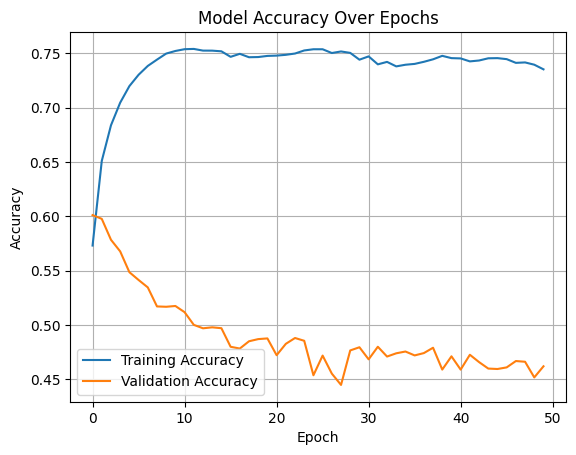

In [20]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
model = tf.keras.models.load_model("vgg-16/")
model.load_weights("savedModels/model_at_epoch_1.h5")
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (Batch  (None, 25088)             100352    
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                        

In [36]:
",".join(label_encoder.get_vocabulary())
len(label_encoder.get_vocabulary())

76

In [37]:
preds=model.predict(test_ds, verbose=1) # predict on the test data
print("done")

1561/1563 [============================>.] - ETA: 0s  

W0000 00:00:1744282326.021911     885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744282326.022498     885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744282326.023051     885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744282326.023856     885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744282326.025184     885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744282326.026036     885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744282326.027868     885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744282326.028656     885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744282326.030100     885 gp

1563/1563 [==============================] - 61s 39ms/step


W0000 00:00:1744282326.223506     885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744282326.226714     885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744282326.230578     885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744282326.234565     885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744282326.238324     885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744282326.242061     885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744282326.246797     885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744282326.250867     885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744282326.253612     885 gp

done


In [38]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
sns.set_style('darkgrid')
classes=label_encoder.get_vocabulary() # ordered list of class names
ytrue=[]
for images, label in tqdm(test_ds):   
    for e in label:
        ytrue.append(classes[e]) # list of class names associated with each image file in test dataset 
ypred=[]
errors=0
count=0

for i, p in tqdm(enumerate(preds)):
    count +=1;
    
    index=np.argmax(p) # get index of prediction with highest probability
    print (index,end="\r")
    klass=classes[index] 
    ypred.append(klass)  
    if klass != ytrue[i]:
        errors +=1
    
acc= (count-errors)* 100/count
msg=f'there were {count-errors} correct predictions in {count} tests for an accuracy of {acc:6.2f} % '

print(msg) 
ypred=np.array(ypred)
ytrue=np.array(ytrue)

# create a confusion matrix 


2025-04-10 10:53:07.237688: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
100%|███████████████████████████████████████| 1563/1563 [01:00<00:00, 25.73it/s]
50000it [00:00, 293983.52it/s]

there were 30472 correct predictions in 50000 tests for an accuracy of  60.94 % 


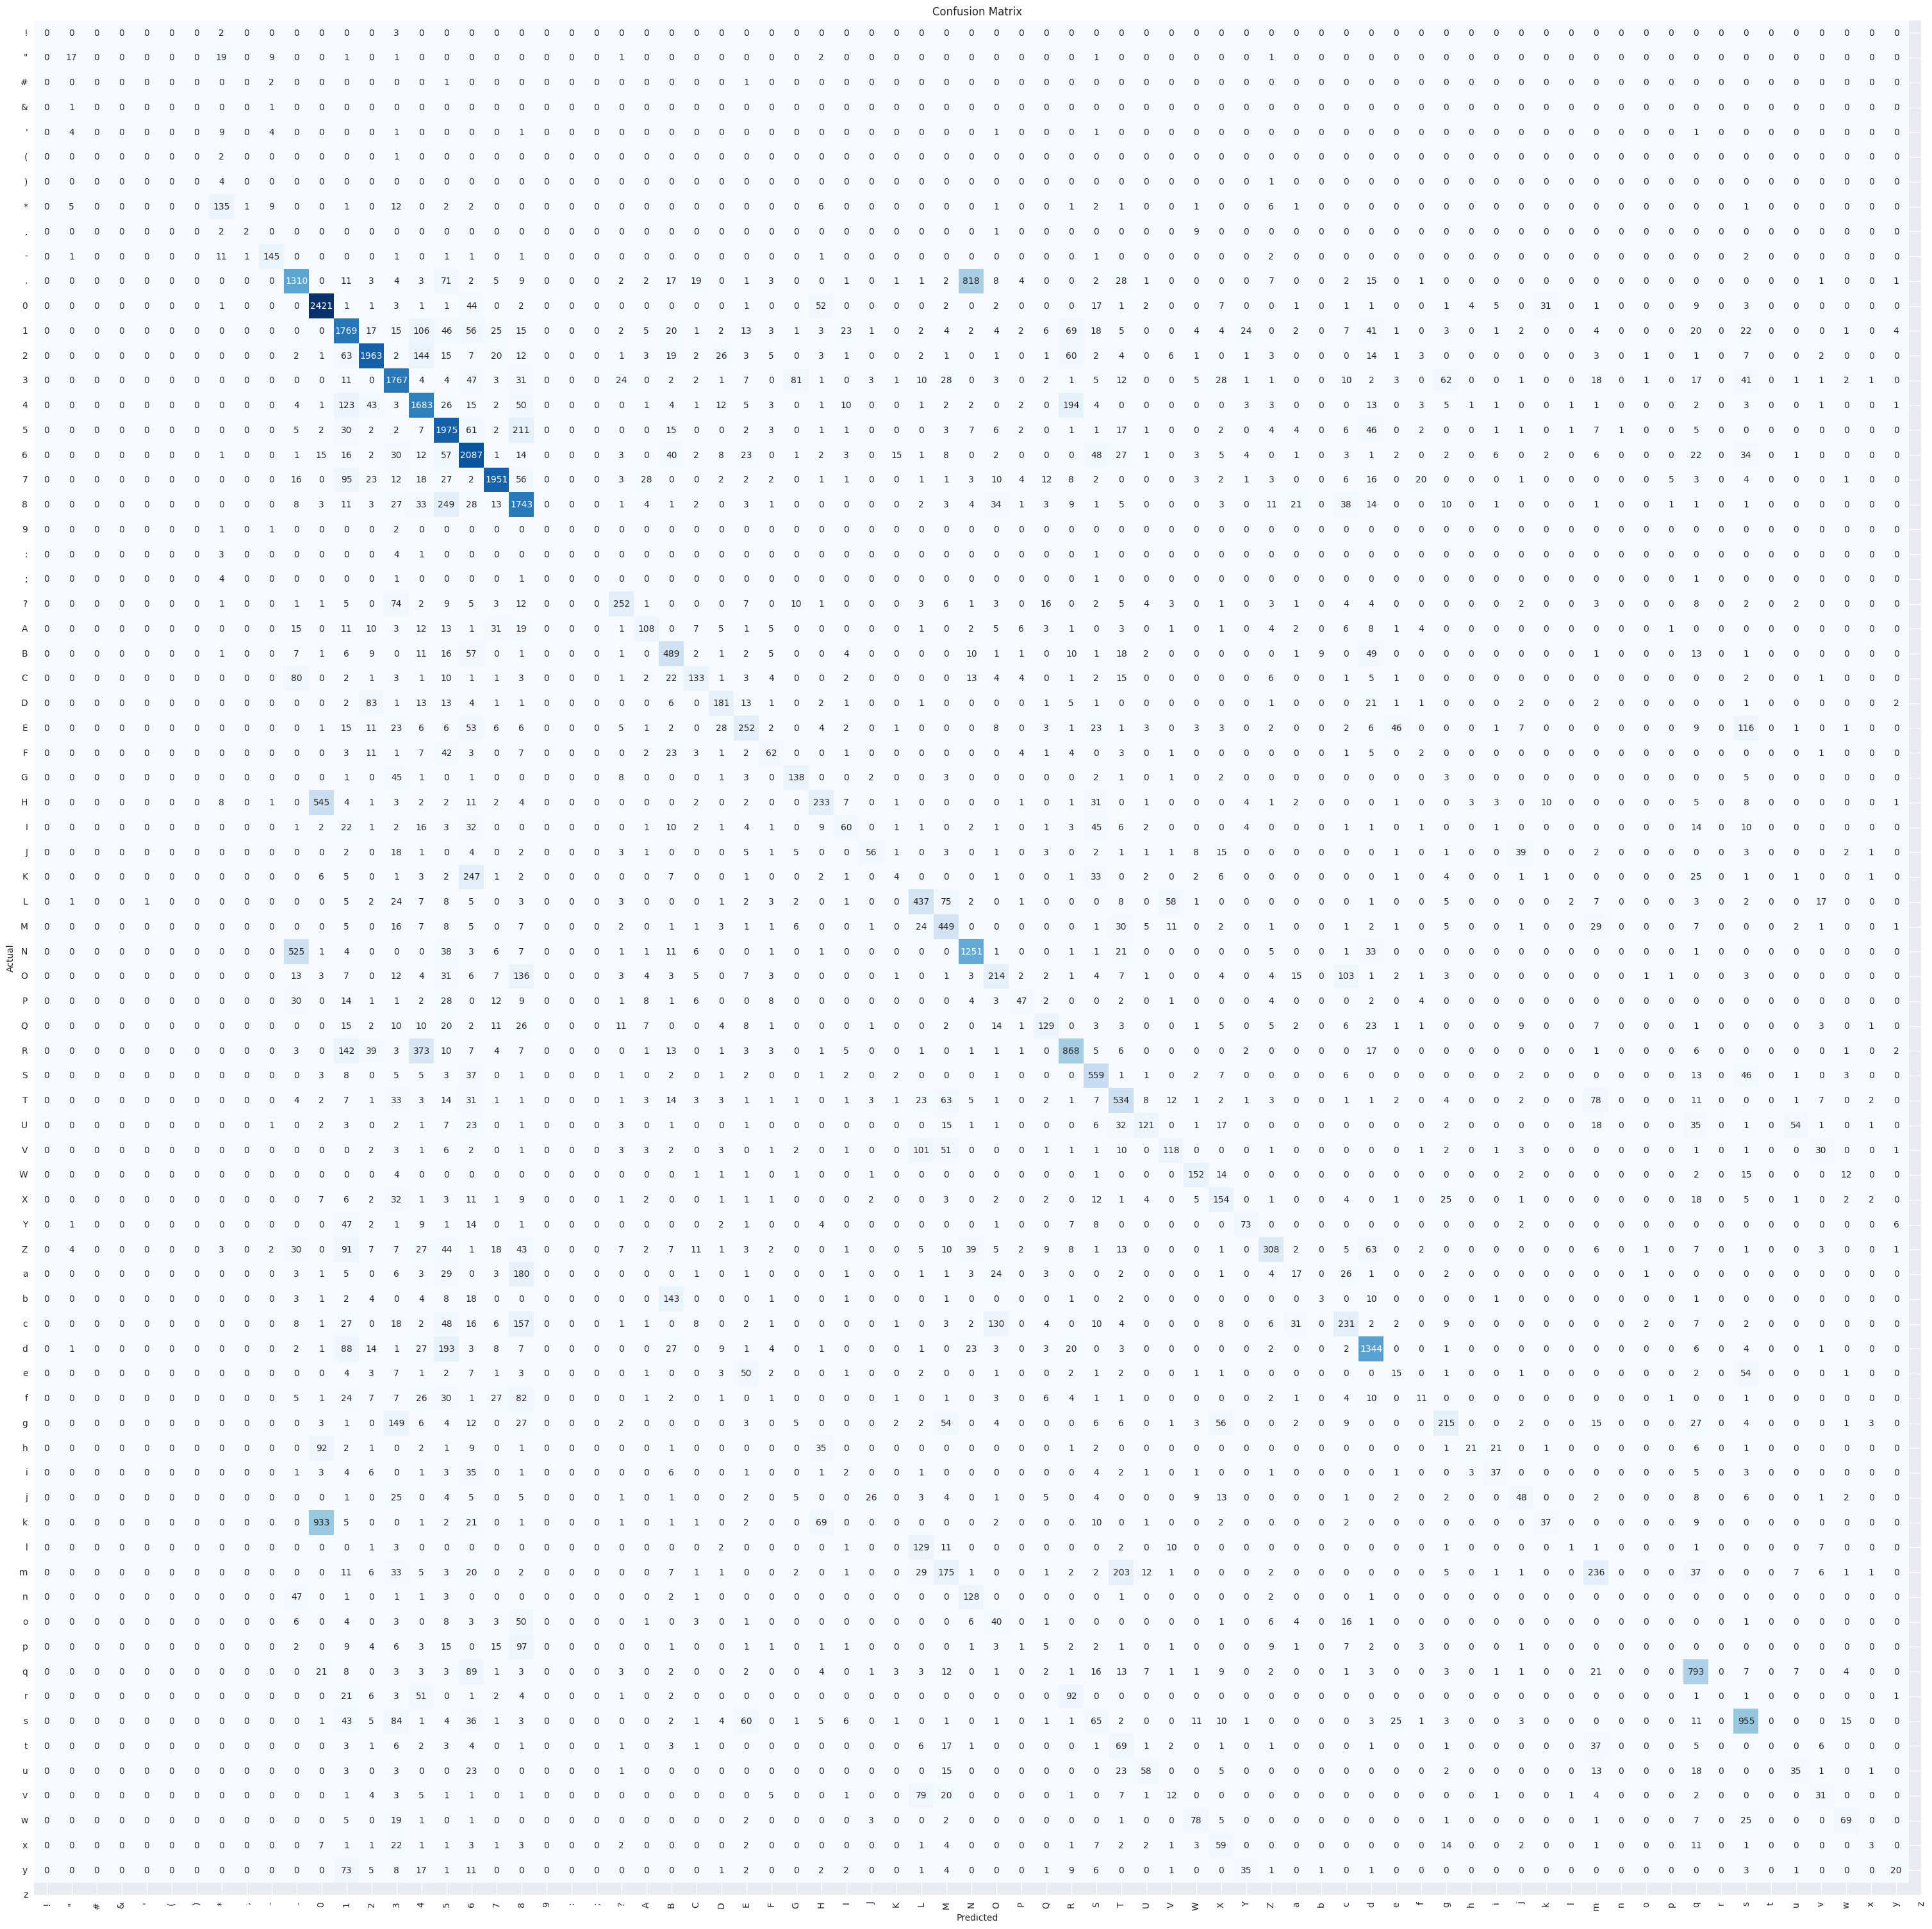

In [39]:
cm = confusion_matrix(ytrue, ypred )        
length=len(classes)
if length<8:
    fig_width=8
    fig_height=8
else:
    fig_width= int(length * .5)
    fig_height= int(length * .5)
plt.figure(figsize=(fig_width, fig_height))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(length)+.5, classes, rotation= 90)
plt.yticks(np.arange(length)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
